# Image classification with TensorFlow 

Based on an original notebook by the TensorFlow authors, licensed under Apache 2.0.

Use **Shift + Enter** to run the cells. When prompted, click **Run anyway** then **Yes**. Try it on this cell...

## Overview

In this notebook, we're going to classify some images of fossils... in fewer than 80 lines of code.

A 'notebook' is an interactive coding and note-taking environment. We're going to be using some cutting edge technology, right in your browser. We will see:

- A deep neural network in action.
- Google's TensorFlow deep learning library.

There are fewer than 80 lines of code altogether.

In [1]:
import numpy as np
import tensorflow as tf

tf.__version__

'2.1.0'

## Load the data

We'll begin by downloading the dataset. Run this cell:

In [2]:
# Note that these commands load tf-friendly shapes.
# import requests
# from io import BytesIO

# X_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/image_X.npy")
# y_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/integer_y.npy")

# X = np.load(BytesIO(X_.content))
# y = np.load(BytesIO(y_.content))

# print("Data loaded!")

In [3]:
# These load scikit-friendly shapes.
X = np.load('../data/fossils/X.npy')
y = np.load('../data/fossils/y.npy')

In [4]:
X.shape

(586, 1024)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=186)

X_val.shape

(186, 1024)

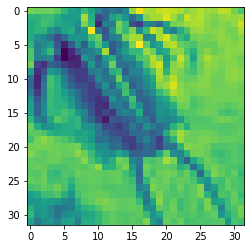

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape(32, 32))

In [7]:
y_val

array(['ammonites', 'ammonites', 'trilobites', 'ammonites', 'fish',
       'trilobites', 'fish', 'fish', 'ammonites', 'ammonites', 'fish',
       'fish', 'trilobites', 'fish', 'trilobites', 'ammonites',
       'ammonites', 'fish', 'ammonites', 'ammonites', 'ammonites',
       'trilobites', 'trilobites', 'fish', 'trilobites', 'fish',
       'ammonites', 'trilobites', 'fish', 'trilobites', 'ammonites',
       'fish', 'trilobites', 'fish', 'fish', 'trilobites', 'ammonites',
       'trilobites', 'trilobites', 'fish', 'ammonites', 'ammonites',
       'trilobites', 'fish', 'trilobites', 'fish', 'trilobites',
       'ammonites', 'trilobites', 'fish', 'trilobites', 'ammonites',
       'trilobites', 'fish', 'fish', 'ammonites', 'trilobites',
       'ammonites', 'trilobites', 'trilobites', 'ammonites', 'fish',
       'trilobites', 'fish', 'fish', 'ammonites', 'fish', 'trilobites',
       'ammonites', 'trilobites', 'fish', 'fish', 'trilobites', 'fish',
       'trilobites', 'fish', 'ammonites', 't

## Shallow learning model

In [9]:
X_train.shape, X_val.shape

((400, 1024), (186, 1024))

In [12]:
from sklearn.svm import SVC



Evaluating the model, we see that we got about 60% accuracy:

## Deep learning model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

TensorFlow is going to want different shaped inputs from what we're used to:

In [8]:
X_train = X_train.reshape(-1, 32, 32, 1)
X_val = X_val.reshape(-1, 32, 32, 1)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(32, 32, 1)))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(3))
model.add(tf.keras.layers.Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0

## Train the network

To begin training, compile the model, then use its `.fit()` method.

In [11]:
import os

model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [12]:
%load_ext tensorboard

import datetime

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
# Run this in the notebook or on the command line (without the magic %):
%tensorboard --logdir logs/fit

In [14]:
model.fit(
    X_train, y_train,
    epochs=32,
    batch_size=16,
    validation_data=(X_val, y_val),
    validation_freq=4,
    callbacks=[tensorboard_callback]
)

Train on 400 samples, validate on 186 samples
Epoch 1/32
400/400 [==============================] - 3s 7ms/sample - loss: 1.6768 - sparse_categorical_accuracy: 0.4975
Epoch 2/32
400/400 [==============================] - 1s 3ms/sample - loss: 1.1190 - sparse_categorical_accuracy: 0.5600
Epoch 3/32
400/400 [==============================] - 1s 3ms/sample - loss: 1.0274 - sparse_categorical_accuracy: 0.5825
Epoch 4/32
400/400 [==============================] - 1s 4ms/sample - loss: 0.8941 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.1109 - val_sparse_categorical_accuracy: 0.3817
Epoch 5/32
400/400 [==============================] - 1s 3ms/sample - loss: 0.9281 - sparse_categorical_accuracy: 0.6275
Epoch 6/32
400/400 [==============================] - 2s 4ms/sample - loss: 0.8834 - sparse_categorical_accuracy: 0.6300
Epoch 7/32
400/400 [==============================] - 1s 3ms/sample - loss: 0.8950 - sparse_categorical_accuracy: 0.6075
Epoch 8/32
400/400 [==========================

## Check the results (inference)

Now that you are done training, see how well the model can predict fossil types.

In [15]:
LABEL_NAMES = le.classes_

In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_hat = np.argmax(y_pred, axis=-1)

print(classification_report(y_val, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84        56
           1       0.73      0.94      0.82        64
           2       0.76      0.67      0.71        66

    accuracy                           0.79       186
   macro avg       0.81      0.79      0.79       186
weighted avg       0.80      0.79      0.79       186



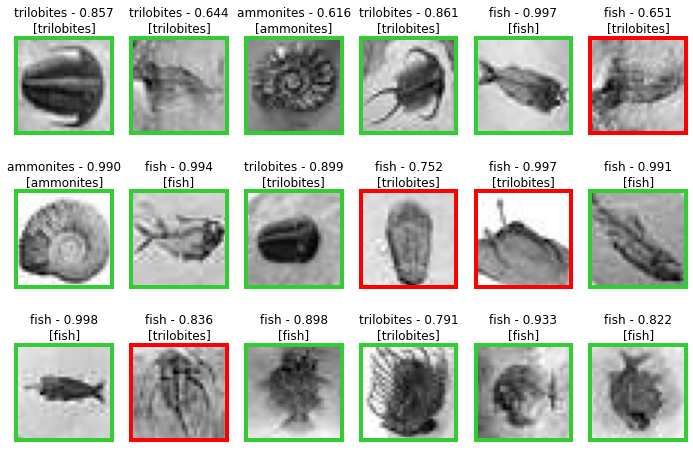

In [21]:
from utils import visualize

visualize(X_val, y_val, y_pred, classes=LABEL_NAMES)

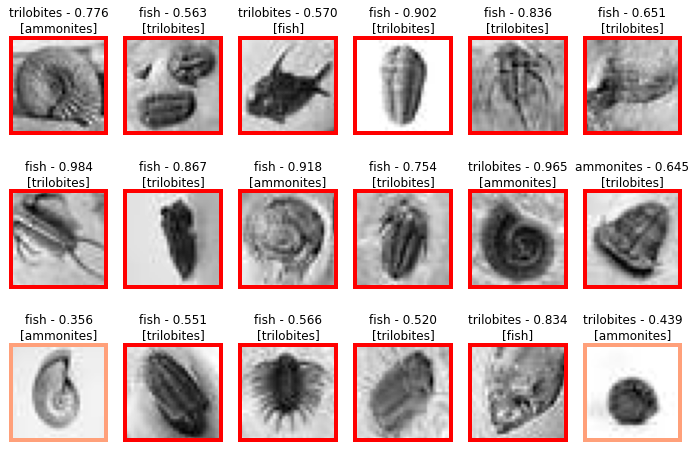

In [22]:
# Incorrectly classified only.
wrong_idx = np.argmax(y_pred, axis=-1) != y_val
y_pred_ = y_pred[wrong_idx]
y_val_ = y_val[wrong_idx]
X_val_ = X_val[wrong_idx]

visualize(X_val_, y_val_, y_pred_, classes=LABEL_NAMES)

## Look at weights

You can get at the weights with the `get_weights()` method, but most of them won't mean much:

In [23]:
for i, w in enumerate(np.array(model.get_weights())):
    print(i, w.T.shape)

0 (1,)
1 (1,)
2 (1,)
3 (1,)
4 (64, 1, 5, 5)
5 (64,)
6 (64,)
7 (64,)
8 (64,)
9 (64,)
10 (32, 64, 5, 5)
11 (32,)
12 (32, 288)
13 (32,)
14 (3, 32)
15 (3,)


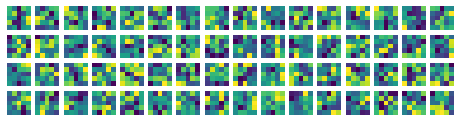

In [24]:
fig, axs = plt.subplots(ncols=16, nrows=4, figsize=(8, 2))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(model.get_weights()[4].T[i, 0])
    ax.axis('off')